# Section 1

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
coins = ("BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD")

train_start = "2023-08-01"
train_end = "2024-08-01"
test_start = "2024-08-01"
test_end = "2024-12-01"

start_date = "2023-08-01"
end_date = "2024-12-01"

In [3]:
def get_coins_data(coins, start, end):
    data_dict = {}
    for coin in coins:
        data_dict[coin] = (
            yf.Ticker(coin).history(start=start, end=end, interval="1d").Close
        )

    data = pd.DataFrame(data_dict)
    data = data.dropna()
    return data

In [4]:
data = get_coins_data(coins, start_date, end_date)
data = data.dropna()

In [5]:
train_data = data.loc[train_start:train_end]
test_data = data.loc[test_start:test_end]

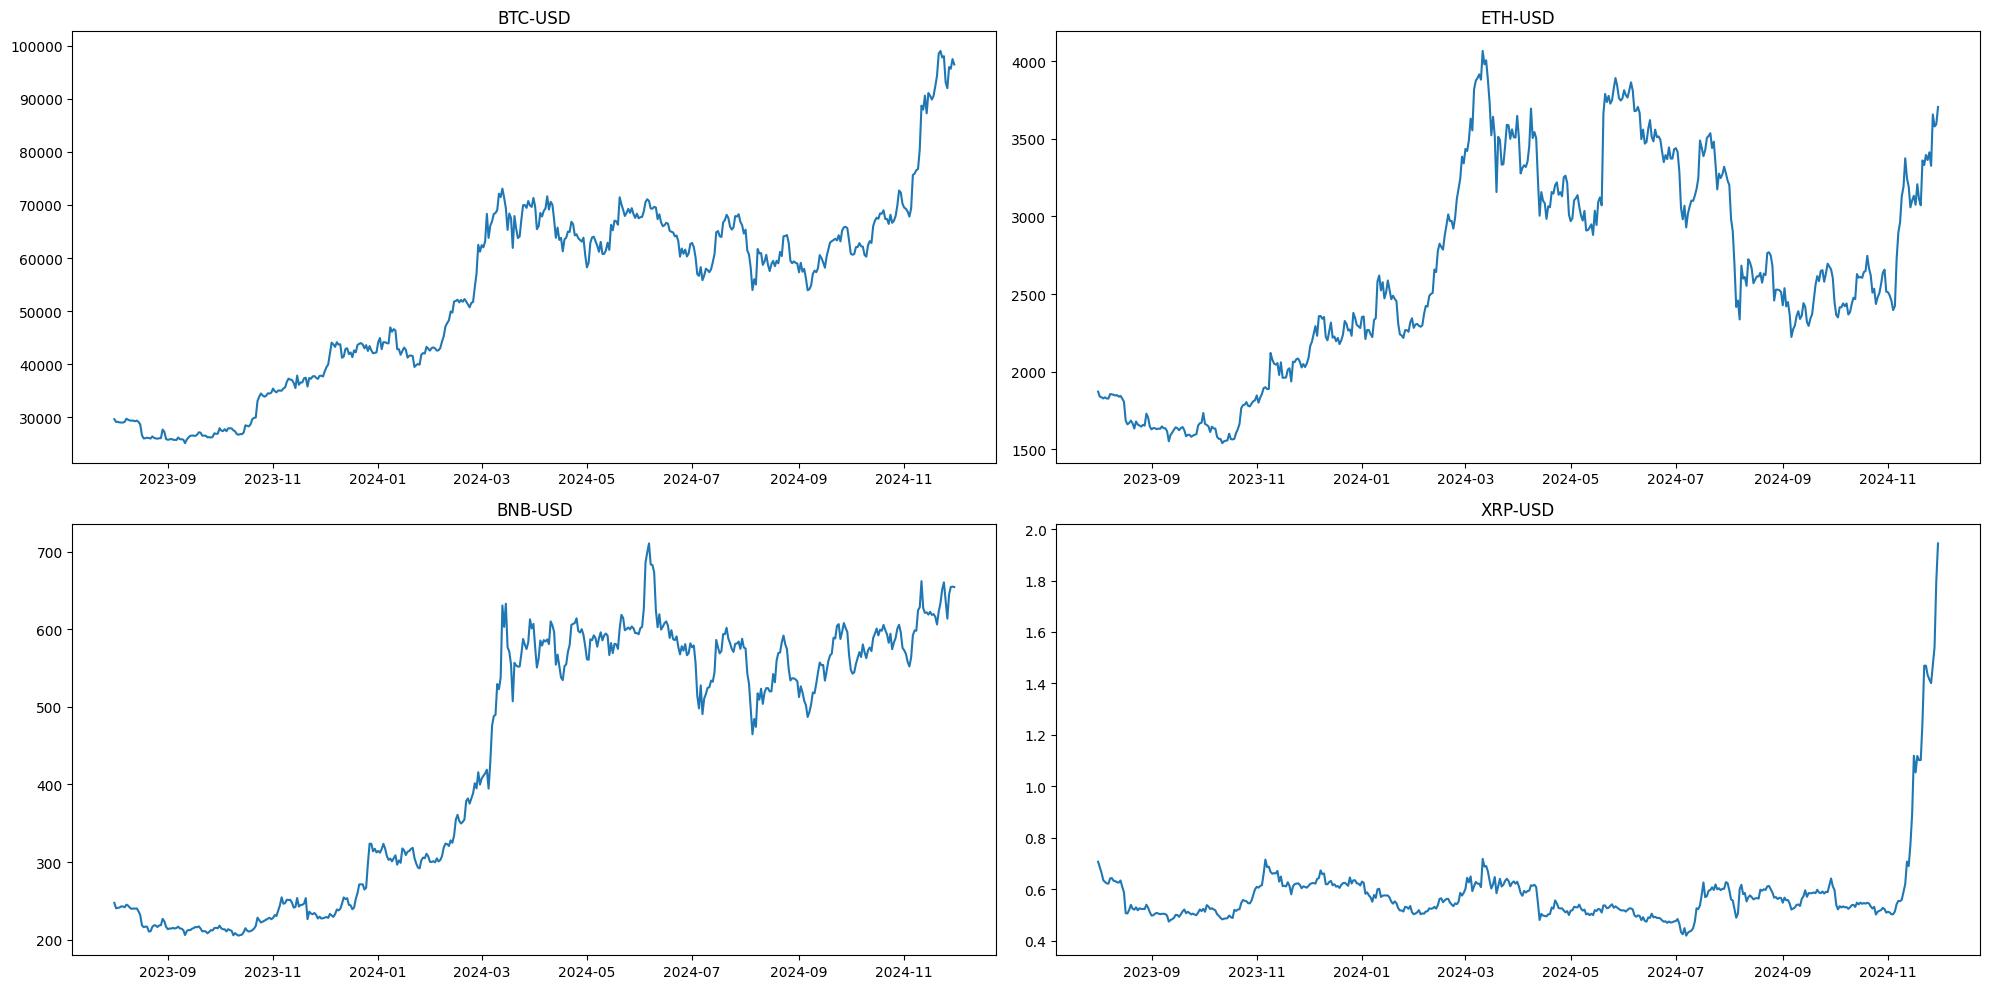

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axes[0, 0].plot(data["BTC-USD"])
axes[0, 0].set_title("BTC-USD")

axes[0, 1].plot(data["ETH-USD"])
axes[0, 1].set_title("ETH-USD")

axes[1, 0].plot(data["BNB-USD"])
axes[1, 0].set_title("BNB-USD")

axes[1, 1].plot(data["XRP-USD"])
axes[1, 1].set_title("XRP-USD")

fig.tight_layout()
plt.show()

# Section 2

## Part 1

In [7]:
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statistics import mean
from arch import arch_model

In [8]:
def mean_forecast(model_type, returns: pd.Series, window):
    volatilities = []
    data = returns.copy(deep=True).to_list()

    for i in range(window):
        model = arch_model(data, vol=model_type, p=1, q=1, rescale=True)
        model_fit = model.fit(disp="off", show_warning=False)
        forecast = model_fit.forecast(horizon=1)
        forecast = np.sqrt(forecast.variance.values[-1, :][0])
        volatilities.append(forecast)
        data.append(forecast)

    return mean(volatilities), volatilities

In [9]:
returns = 100 * train_data.pct_change().dropna()
windows = [7, 30]
columns = pd.MultiIndex.from_tuples(
    [(coin, window) for coin, window in list(itertools.product(coins, windows))]
)
indexes = ["Garch", "EGarch", "FIGarch"]
volatilities = pd.DataFrame(index=indexes, columns=columns)
predicted_volatilities = {7: {}, 30: {}}

for coin, window in list(itertools.product(coins, windows)):

    garch_vol_mean, garch_vol = mean_forecast("GARCH", returns[coin], window)
    egarch_vol_mean, egarch_vol = mean_forecast("EGARCH", returns[coin], window)
    figarch_vol_mean, figarch_vol = mean_forecast("FIGARCH", returns[coin], window)
    volatilities.loc["Garch", (coin, window)] = garch_vol_mean
    volatilities.loc["EGarch", (coin, window)] = egarch_vol_mean
    volatilities.loc["FIGarch", (coin, window)] = figarch_vol_mean
    predicted_volatilities[window][coin] = {
        "garch": garch_vol,
        "egarch": egarch_vol,
        "figarch": figarch_vol,
    }

In [10]:
volatilities

BTC-USD              ETH-USD               BNB-USD            \
               7         30         7           30        7         30   
Garch    2.350822  2.358935   3.413278    3.399992  2.210343  2.432097   
EGarch   2.528368  2.668457  80.852875  221.384906  2.520949  3.431927   
FIGarch   2.43328     2.424   2.872986    2.868511  2.581769  2.819749   

          XRP-USD            
               7         30  
Garch    3.172131  3.227249  
EGarch    3.41076  3.252874  
FIGarch  3.806327   3.52197

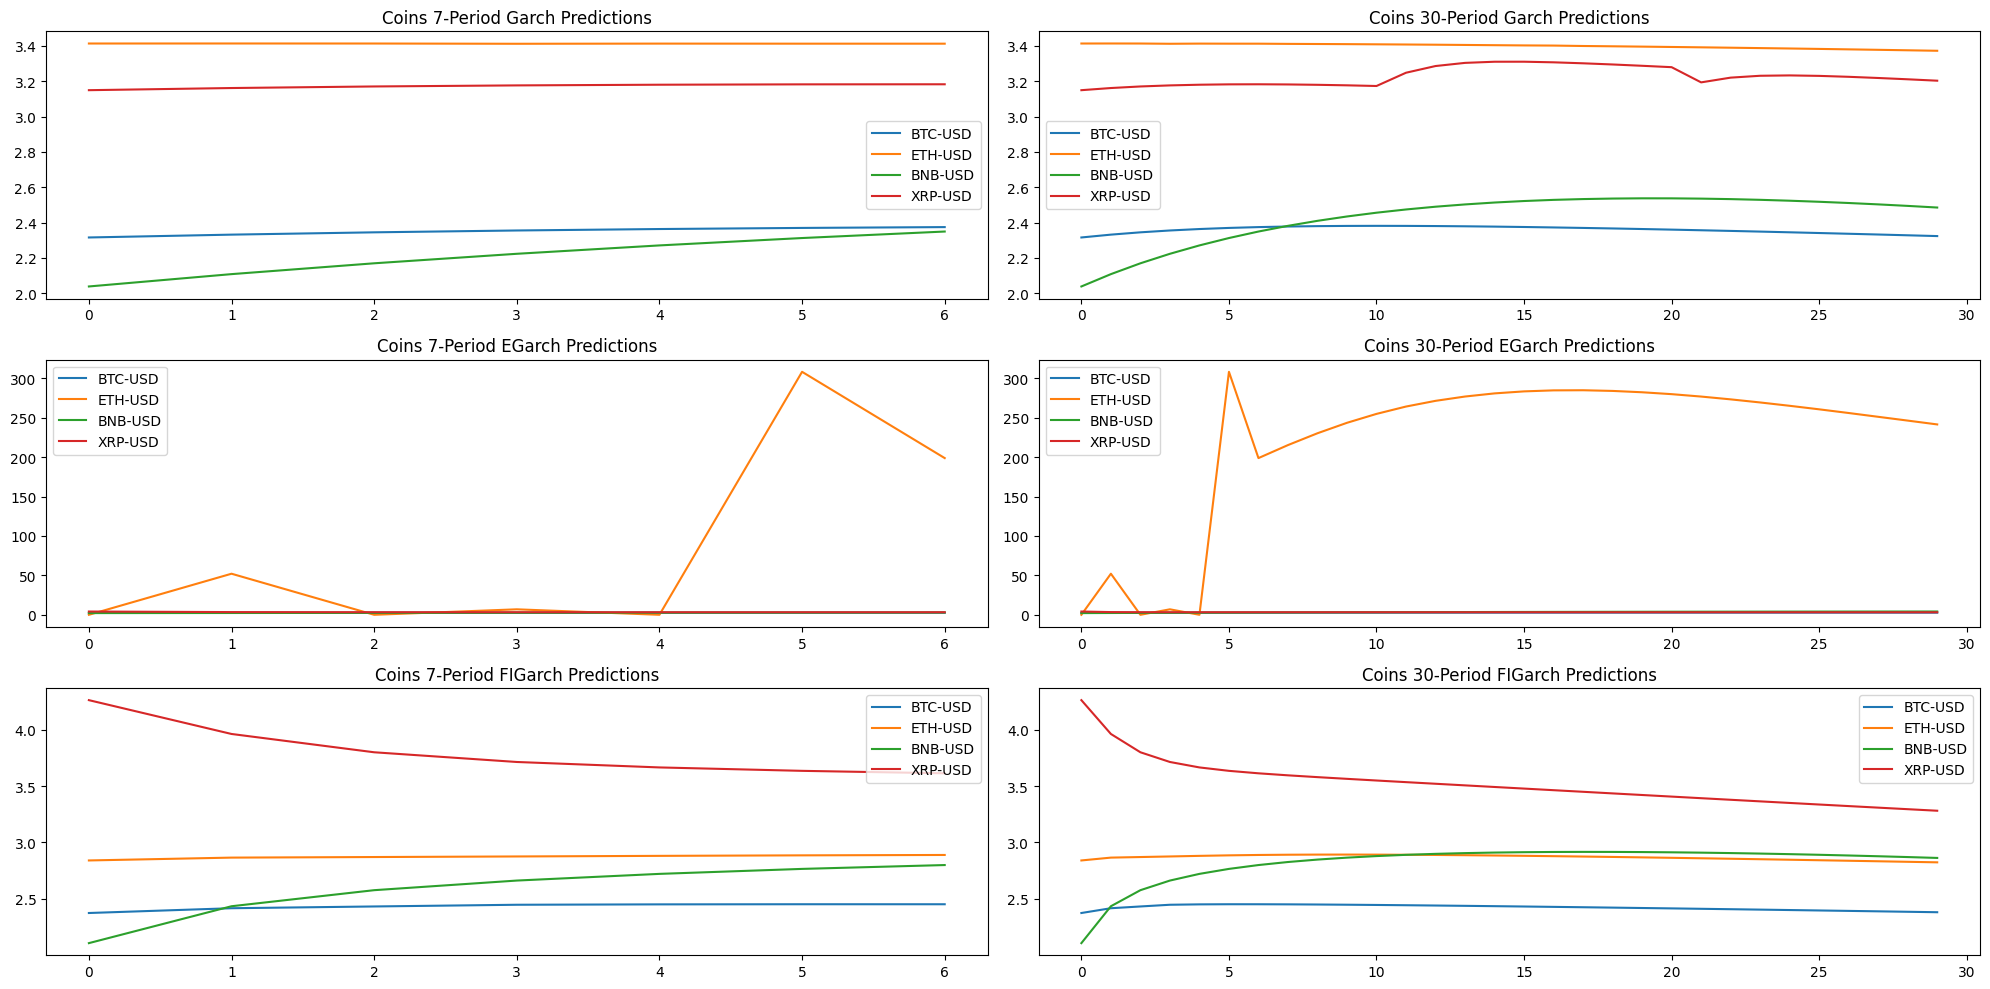

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

for coin in coins:
    axes[0, 0].plot(predicted_volatilities[7][coin]["garch"], label=f"{coin}")
    axes[0, 0].set_title("Coins 7-Period Garch Predictions")
    axes[0, 0].legend()

    axes[0, 1].plot(predicted_volatilities[30][coin]["garch"], label=f"{coin}")
    axes[0, 1].set_title("Coins 30-Period Garch Predictions")
    axes[0, 1].legend()

    axes[1, 0].plot(predicted_volatilities[7][coin]["egarch"], label=f"{coin}")
    axes[1, 0].set_title("Coins 7-Period EGarch Predictions")
    axes[1, 0].legend()

    axes[1, 1].plot(predicted_volatilities[30][coin]["egarch"], label=f"{coin}")
    axes[1, 1].set_title("Coins 30-Period EGarch Predictions")
    axes[1, 1].legend()

    axes[2, 0].plot(predicted_volatilities[7][coin]["figarch"], label=f"{coin}")
    axes[2, 0].set_title("Coins 7-Period FIGarch Predictions")
    axes[2, 0].legend()

    axes[2, 1].plot(predicted_volatilities[30][coin]["figarch"], label=f"{coin}")
    axes[2, 1].set_title("Coins 30-Period FIGarch Predictions")
    axes[2, 1].legend()

fig.tight_layout()
plt.show()